Age / Exposure Tracers for Bloom Analysis
==

This is a retake on the early analysis of DWAQ-based tracers, but using an
online-coupled DFM run.

The 2022-08-04 to 2022-08-30 run took 2.2 days, about 11x realtime.

This version includes upward swimming at 0, 10, and 20 m/d, and disables temperature.

In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [22]:
import os, glob, shutil
import datetime
import six
import xarray as xr
import pandas as pd
import re

from stompy.spatial import field
from stompy import utils
from stompy.plot import plot_wkb
import xarray as xr
from scipy import ndimage

import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

In [3]:
import bloom_common

DFM-based Runs
==

In [5]:
# restart files every 10 days, plus a restart file on 2022-08-01.
# speed was 85x realtime on 16 cores.
# Forcing should all be okay to copy/link for restarts.

if 1: # Check on map and rst output:
    dfm_base_run_dir="dfm_spinup"
    map_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220501_000000_map.nc")
    rst_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220801_000000_rst.nc")
    
map_ds=xr.open_dataset(map_fn)
rst_ds=xr.open_dataset(rst_fn)

In [6]:
six.moves.reload_module(dfm)
six.moves.reload_module(dwaq)
six.moves.reload_module(bloom_common)

<module 'bloom_common' from '/richmondvol1/rusty/wy2022_bloom/bloom_common.py'>

In [20]:
grid = unstructured_grid.UnstructuredGrid.read_dfm("dfm_spinup/sfei_v20_net.nc")
shore_poly = grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors


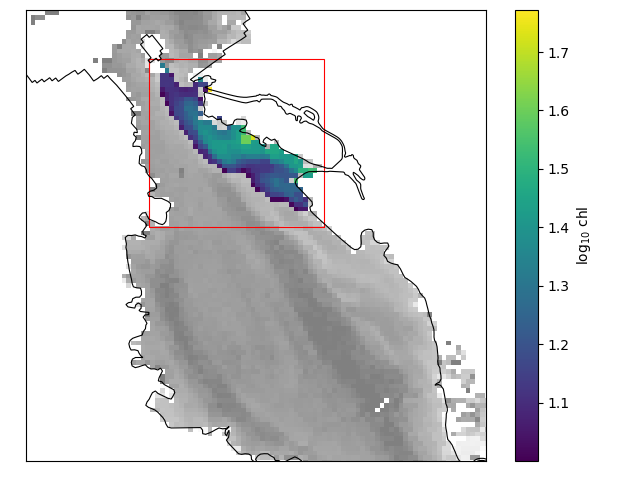

In [69]:
# Load a RS scene for the initial condition. Different format than what bloom_common.load_chl_scenes 
# expects.
six.moves.reload_module(field)
rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"
scene="20220804_S3A_OL_NT_CHL_LOG10.img" # bloom not that obvious.
#scene="20220805_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
#scene="20220806_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
#scene="20220807_S3A_OL_NT_CHL_LOG10.img" # decent, though getting late.
rs_chl_fn=os.path.join(rs_chl_dir,scene)
rs_chl_log10 = field.GdalGrid(rs_chl_fn)

# clip and remove specks.

fig,ax=plt.subplots()
ax.set_adjustable('datalim')

img0=rs_chl_log10.plot(cmap='gray',alpha=0.5)
img0.set_clim(0,2)
valid = np.isfinite(rs_chl_log10.F)
#valid = ndimage.binary_erosion(valid,iterations=1) # remove specks
valid = valid & rs_chl_log10.polygon_mask(shore_poly) 
rs_chl_log10.F[~valid]=np.nan
rs_chl_log10.F = ndimage.median_filter(rs_chl_log10.F,size=3)
rs_chl_log10.F[ rs_chl_log10.F<1.0 ] = np.nan

# limit IC to within a bounding box
bbox=(555140, 567000, 4174362, 4185757)
in_box = rs_chl_log10.xxyy_mask( bbox )
rs_chl_log10.F[ ~in_box ] = np.nan
geo_bbox = geometry.box(bbox[0],bbox[2],bbox[1],bbox[3])
plot_wkb.plot_wkb(geo_bbox,lw=0.8,ec='r',fc='none')
img=rs_chl_log10.plot()
#img.set_clim(0,2)
plt.colorbar(img, label="log$_{10}$ chl")
ax.axis((548224, 576581, 4158516, 4189141))

plot_wkb.plot_wkb(shore_poly, ax=ax, fc='none',ec='k',lw=0.8)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.subplots_adjust(left=0.04,right=0.94,top=0.98,bottom=0.04)

chl_IC = rs_chl_log10.copy()
chl_IC.F = chl_IC.F**10
chl_IC.F[ np.isnan(chl_IC.F) ] = 0.0

In [74]:
# First, get a basic restart going
from stompy.model.delft import custom_process

class Model(custom_process.CustomProcesses,bloom_common.SFBRestartable):
    dwaq=True
    temperature=False
    kd_path="../Kd_2022/Kd_sentinel3_1h/Kd_sent3_20220801_20220901.nc"

    inputs_static=("/boisevol1/hpcshared/open_bay/hydro/full_res"
                   "/wy2022_r52184/sfb_dfm/inputs-static/")

    swim_speeds=[0.0, -10.0/86400.0, -20.0/86400.0] # positive down, m/s
    seg_function_resolution=500.0 # [m] resolution when discretizing spatiotemporal parameter to cartesian grid.
    
    def configure_general(self):
        bloom_common.configure_dfm_t141798()
                
        self.mdu['output','WaqInterval']="" # no need for DWAQ output
        self.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
        self.mpi_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')

        # Some files have moved around, so up date locations
        self.mdu['output','CrsFile' ] = os.path.join(self.inputs_static, "SB-observationcrosssection.pli")
        self.mdu['output','MapInterval' ] = 3600
        self.mdu['geometry','LandBoundaryFile'] = os.path.join(self.inputs_static,"deltabay.ldb")
        self.mdu['geometry','FixedWeirFile'] = os.path.join(self.inputs_static,"SBlevees_tdk.pli")

        # run_dfm_rs_chl for other entries that may have to be dropped.
        del self.mdu['waves','WaveNikuradse']

        if not self.temperature:
            self.mdu['physics','Temperature'] = 0 # and fix-up tracers below

        # for non-restart this is handled by configure(), but restart doesn't call that.
        if self.dwaq is True:                                                                                              
            self.dwaq=dwaq.WaqOnlineModel(model=self)
            
    def set_bloom_tracers(self):
        self.my_tracers=[]
        
        # I think the steps are
        #  1. add the tracer definitions to forcing data via appending/updating FlowFMold_bnd.ext
        #  2. add/overwrite the tracers in the restart file.
        
        tracers=[]

        #release_poly = bloom_common.oakland_poly
        release_poly = None
        release_raster = chl_IC

        # Not sure whether we'll be able to do vertical swimming here,
        # but keep the machinery around in case.
        
        for swim_i,swim_speed in enumerate(self.swim_speeds): # positive down, m/s
            # Names must be <=10 characters!
            conc='conc' + str(swim_i)
            #agec='agec' + str(swim_i)
            #depc='depc' + str(swim_i)
            radc='radc' + str(swim_i)

            # basic age. For instantaneous release we know the answer,
            # but that will serve as a check once we attempt swimming.
            #self.custom_CART(conc=conc,age_conc=agec)
            #self.custom_CART(conc=conc,age_conc=depc,partial="LocalDepth")
            self.custom_CART(conc=conc,age_conc=radc,partial='RadBot')

            # Drop complicated machinery for updating vertically variable RS scenes.
            # Even with swimming will use a mixed IC.
            def tracer_blob(rst_ds,values_cell_layer):
                # Dropped uniform tracer code.
                xy=np.c_[ rst_ds.FlowElem_xzw.values, rst_ds.FlowElem_yzw.values]

                if release_poly is not None:
                    in_poly = [release_poly.contains(geometry.Point(p)) for p in xy]
                    value_2d = np.array(in_poly)
                else:
                    value_2d = release_raster(xy)
                    # raster may not be large enough to cover domain.
                    value_2d[ np.isnan(value_2d) ] = 0.0
                
                # mixed initial_condition
                values_cell_layer[:,:] = value_2d[:,None]
            def tracer_zero(rst_ds,values_cell_layer):
                values_cell_layer[:,:] = 0.0

            # Unsure of whether this is the right place to do settling, or if it should
            # be through DWAQ.
            tracers.append( dict(name=conc,func=tracer_blob,fall_velocity_m_s=swim_speed))            
            #tracers.append( dict(name=agec,func=tracer_zero,fall_velocity_m_s=swim_speed))            
            #tracers.append( dict(name=depc,func=tracer_zero,fall_velocity_m_s=swim_speed))            
            tracers.append( dict(name=radc,func=tracer_zero,fall_velocity_m_s=swim_speed))

        for tracer in tracers:
            # Initials don't really matter here as they are manually written to restart files.
            self.dwaq.substances[tracer['name']]=dwaq.Substance(initial=0)
            
        self.my_tracers=tracers
        # Adding the tracers to the ext file doesn't happen until copy_file_for_restart
        # likewise, will have to modify the restart files later.

    def update_restart_with_tracers(self):
        def modify_ic(rst_ds,**kw):
            for tracer in self.my_tracers:
                name=tracer['name']
                func=tracer['func']
                self.log.info(f"Setting tracer {name} in restart file")
                # mimic sa1 tracer
                salt=rst_ds['sa1']
                values=salt.values.copy() # ('time','nFlowElem','laydim')
                values[...] = 0.0 # don't accidentally write salt data though
                
                # updates values in place.
                func(rst_ds=rst_ds,values_cell_layer=values[0,:,:])
                rst_ds[name]=salt.dims, values
                for aname in ['coordinates','grid_mapping']:
                    if aname in salt.attrs:
                        rst_ds[name].attrs[aname]=salt.attrs[aname]
        self.modify_restart_data(modify_ic)
                
    def add_tracers_to_bcs(self):
        # take a more low-level approach compared to usual BC configuration
        # so that we can be very careful about what things change.
        ext_fn=self.mdu.filepath(('external forcing','ExtForceFile'))
        orig_ext_fn=ext_fn+".orig"
        shutil.copyfile(ext_fn,orig_ext_fn)

        bcs=self.parse_old_bc(orig_ext_fn)
        
        new_tracer_names=[t['name'] for t in self.my_tracers]
        configured_tracers={}
        
        # For now all boundary conditions for all new tracers are 0.
        # Note that establishing order here is very confusing. If these
        # need to be nonzero, it will take some work to know
        # it's correct. probably the strategy should be to filter out 
        # all existing BCs for these tracers, and then write them at the
        # end in our prescribed order. This [I think] is what it does
        # currently.
        new_bc_values=[0.0 for t in self.my_tracers]

        def name_matches(cfg_name):
            for tracer in tracers:
                if tracer['name'].lower() == cfg_name.lower():
                    if tracer['name']!=cfg_name:
                        print(f"Careful - case mismatch {cfg_name} vs {tracer['name']}")
                    return True
            return False
            
        with open(ext_fn,'wt') as fp_new:
            for rec in bcs:
                write_verbatim=True
                
                quantity=rec['QUANTITY']
                if quantity.upper().startswith('INITIALTRACER'):
                    tracer_name=quantity[len("INITIALTRACER"):]
                    continue
                elif quantity.upper().startswith('TRACERBND'):
                    tracer_name=quantity[len("TRACERBND"):]
                    continue
                elif ((not self.temperature) 
                      and 
                      (quantity.upper() in ['TEMPERATUREBND','INITIALTEMPERATURE',
                                            'HUMIDITY_AIRTEMPERATURE_CLOUDINESS'])):
                    continue
                elif quantity.upper().startswith('DISCHARGE_SALINITY_TEMPERATURE_SORSIN'):
                    print("Source/sink BC entry")
                    # Yuck - have to add or remove new column(s). This only involves rewriting 
                    # the data file,though. The stanza is unchanged.
                    # Now that we drop temperature, I think orig_num_values goes from 3 to 2.
                    if self.temperature:
                        orig_num_values = 3
                    else:
                        orig_num_values = 2
                    self.add_tracer_bcs(rec,new_values=new_bc_values,orig_num_values=orig_num_values)

                # At this point nobody ever changes the stanza, it's all written verbatim.
                if write_verbatim:
                    fp_new.write("\n".join(rec['stanza'])+"\n")
                    continue
                
            # And write out our new tracers (including ones that were skipped during 
            # transcription above
            for tracer in self.my_tracers:
                name=tracer['name']
                ic_fn=f"dummy-{name}.xyz"
                with open(os.path.join(self.run_dir,ic_fn),'wt') as fp_xyz:
                    fp_xyz.write("550000 4180000 0.0\n")
                fp_new.write("\n# NEW TRACERS\n"
                             f"QUANTITY=initialtracer{name}\n"
                             f"FILENAME={ic_fn}\n"
                             "FILETYPE=7\n"
                             "METHOD=5\n"
                             "OPERAND=O\n")
                
                if tracer['fall_velocity_m_s']!=0.0:
                    # Presumably DWAQ-based settling velocity works, too. But that would require
                    # choosing tracers that already have a settling process associated with them,
                    # or to code up a custom settling process. In contrast, if it works to 
                    # set constant settling here, where DFM handles it, things would be much simpler.
                    
                    self.log.warning("Hoping that fall velocity in can be set via DFM instead of DWAQ")
                    w=tracer['fall_velocity_m_s']
                    fp_new.write(f"TRACERFALLVELOCITY={w:.8f}\n")

    def add_tracer_bcs(self,bc,new_values=[],orig_num_values=None):
        """
        Add additional columns to a source/sink data file.
        So if the new run will include two dwaq tracers, pass new_values=[0,1]
        (which would tag sources with 0 for the first and 1.0 for the second)
        orig_num_values: 3 for run with salinity and temperature. I think
        less than that if temperature and/or salinity are disabled. 
        """
        if orig_num_values is None:
            if self.temperature:
                orig_num_values=3
            else:
                orig_num_values=2
                
        # yuck...
        pli_fn=os.path.join(self.run_dir,bc['FILENAME'])
        assert pli_fn.lower().endswith('.pli')
        fn=pli_fn[:-4] + ".tim"
        assert os.path.exists(fn)
        fn_orig=fn+".orig"
        if not os.path.exists(fn_orig):
            shutil.copyfile(fn,fn_orig)
        data_orig=np.loadtxt(fn_orig)
        # drop previous forcing for new tracers. leaving time column and the original Q,S,T values
        columns=[data_orig[:,:1+orig_num_values]] 
        for new_val in new_values:
            columns.append( np.full(data_orig.shape[0],new_val))
        data=np.column_stack(columns)
        np.savetxt(fn,data,fmt="%.6g")

    def fix_ext_paths(self):
        # from run_dfm_rs_chl: Fix paths that have moved in external forcing file.
        # And also in ext boundary file. 
        ext_fn=self.mdu.filepath(('external forcing','ExtForceFile'))
        orig_ext_fn=ext_fn+".orig"
        shutil.copyfile(ext_fn,orig_ext_fn)

        print(f"Trying to fix_ext_paths in {orig_ext_fn} => {ext_fn}")
        with open(orig_ext_fn,'rt') as fp_orig:
            with open(ext_fn,'wt') as fp_new:
                for line in fp_orig:
                    m=re.match(r'\s*filename\s*=\s*([^#]+)(#.*)?',line,re.I)
                    if m:
                        ext_entry = m.group(1).strip()
                        print(f"Checking on filename {ext_entry} in external forcing file")
                        # or should it be the original run directory instead of self.run_dir?
                        real_path=os.path.abspath(os.path.join(self.run_dir,ext_entry))
                        if not os.path.exists(real_path):
                            # If it's from inputs-static replace
                            if os.path.dirname(real_path).endswith('inputs-static'):
                                real_path = os.path.join(self.inputs_static, os.path.basename(real_path))
                                assert os.path.exists(real_path)
                                line=f"FILENAME={real_path}\n"
                            else:
                                raise Exception("redirect here")
                    fp_new.write(line)

    def add_light(self):
        if self.kd_path is None: return
        self.add_kd()
        self.dwaq.add_process(name='CalcRad')
        self.add_insolation()
        # For online coupling this probably has to be put somewhere else.
        self.dwaq.map_output += ('RadBot','ExtVl')
        
    def add_insolation(self):
        if 0:
            self.dwaq.parameters['RadSurf']=500.0 
        else:
            cimis=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
            # Starts as PST, but the model is UTC.
            cimis=cimis.set_coords('time').swap_dims({'Date':'time'})
            cimis['time']=cimis['time']+np.timedelta64(8,'h')
            sol_rad=cimis['HlySolRad'].values
            sol_rad=utils.fill_invalid(sol_rad)
            
            #t0=np.datetime64(self.hydro.time0)
            #t_secs=((cimis.time.values-t0)/np.timedelta64(1,'s')).astype(np.int64)
            param=dwaq.ParameterTemporal(times=cimis.time.values,values=sol_rad)
            self.dwaq.parameters['RadSurf'] = param
        
    def add_kd(self):
        if 0: 
            self.log.warning('Using constant Kd field until online parameter code comes along')
            self.dwaq.parameters['ExtVl'] = dwaq.ParameterConstant(1.0)
            return

        # extrude to 3D, write seg function (which for an online run will be converted to
        # cartesian grid).
        ds=xr.open_dataset(self.kd_path)
        g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
        if not np.allclose(g.cells_centroid(), self.grid.cells_centroid()):
            self.log.warning("Kd field grid is different. Will try to match to hydro grid by centroid")
            n_map,e_map,c_map = self.grid.match_to_grid(g,tol=np.inf)
            # self.match_to_grid(other) returns arrays that can be used to map other_grid_data[c_map]
            # back to self. unlimited tolerance so c_map should have valid indexes everywhere.
            permute = c_map                
        else:
            permute = np.arange(g.Ncells())
        #t0=np.datetime64(self.hydro.time0)
        #tsecs=(ds.time.values-t0)/np.timedelta64(1,'s')
        def seg_func(t,permute=permute):
            C_2d=ds['Kd'].sel(time=t,method='nearest').values
            return self.dwaq.hydro.extrude_element_to_segment(C_2d[permute])
            
        # No self-shading, specify overall extinction directly
        self.dwaq.parameters['ExtVl'] = dwaq.ParameterSpatioTemporal(times=ds.time.values,func_t=seg_func)

class DFMBloomTracer: 
    # v00: just get a run to start...
    # v01: Swimming.
    # v02: more swimming, fewer tracers, maybe RS initial condition.
    name="bloom_tracers_v02"
    
    # Will start from the end of this existing run (which doesn't have the tracers)
    dfm_base_run_dir="dfm_spinup"
    
    restart_copy_names=["source_files"] # copy, because we end up modifying some

    # Will be an instantaneous release -- first phase is to run from the restart (8/1)
    # up to the time of the release.
    # The sentinel 3 data appears to be from 18:11 to 18:38. Assuming that's UTC, which 
    # the model is, too.
    release_time = np.datetime64("2022-08-04 18:20")
    end_time = np.datetime64("2022-08-30")
    
    def run_to_release(self):
        """
        Find a restart point close to release_time. 
        initialize and run to release_time. 
        """
        prev_model=Model.load(self.dfm_base_run_dir)            
        start_time=prev_model.restartable_time()
        assert start_time < self.release_time,f"Need to scan for restart time before last restart"

        # Setup a restart
        model=prev_model.create_restart(deep=True) 
        model.run_stop=self.release_time

        self.setup_and_run(model)

    def run_from_release(self):
        """
        Check for the most recent completed run ending at the release time.
        None if not found.
        Configure restart
        """
        candidates = glob.glob(self.pattern_for_release_run())
        candidates.sort(reverse=True)
        for candidate in candidates: 
            if Model.run_completed(candidate):
                print(f"Will use {candidate} as previous run")
                prev_model = Model.load(candidate)
                break
        else:
            print("No completed runs end at time of release")
            return
            
        # Setup a restart
        model=prev_model.create_restart(deep=True) 
        model.run_stop=self.end_time
        self.setup_and_run(model)

    def setup_and_run(self,model):
        self.set_run_dir(model)
        model.configure_general()
        
        # populates self.my_tracers as a list of dictionaries
        # with ICs, names, etc.
        model.set_bloom_tracers()
        model.add_light()
            
        # This alters the MDU, so do it before write()
        model.update_restart_with_tracers()
        model.write()
        
        # Can fix some things in ext forcing file now
        model.fix_ext_paths()
        # This updates the BC data in place. Do it here so that 
        # we have a starting ext file which will be updated with
        # new tracers.
        model.add_tracers_to_bcs()
        model.partition()
        model.run_simulation()
            
    run_dir_prefix="run"
    def set_run_dir(self,model):
        start_str,stop_str=[ utils.to_datetime(t).strftime("%Y%m%dT%H%M")
                            for t in [model.run_start,model.run_stop]]
        for x in range(20):
            run_dir=os.path.join(self.name,f"{self.run_dir_prefix}_{start_str}_{stop_str}_v{x:02}")
            if not os.path.exists(run_dir): break
        else:
            raise Exception(f"Too many retries for {run_dir}")
        model.run_dir=run_dir
        model.set_restart_file() # kludge. RestartFile needs run_dir.
    def pattern_for_release_run(self):
        stop_str = utils.strftime(self.release_time,"%Y%m%dT%H%M")
        return os.path.join(self.name,f"{self.run_dir_prefix}_*_{stop_str}_v*")
        


In [75]:
bloto=DFMBloomTracer()

bloto.run_to_release()
bloto.run_from_release()

INFO:HydroModel:set_restart_file: Setting RestartFile based on self.restart_from
INFO:HydroModel:set_restart_file: Setting RestartFile based on self.restart_from
INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in restart file
INFO:HydroModel:Setting tracer conc2 in restart file
INFO:HydroModel:Setting tracer radc2 in restart file
INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in restart file
INFO:HydroModel:Setting tracer conc2 in restart file
INFO:HydroModel:Setting tracer radc2 in restart file
INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in res

Would be writing temporal parameter to external forcing file
First call to waqpb_export
 Reading data......
 Writing TRM tables for LaTeX......
 Making PROCES.ASC......
 
+Process: pH_carb   
+Process: DynDepth  
+Process: DynSurf   
+Process: TotDepth  
+Process: Emersion  
+Process: Meteo     
+Process: HeatBal   
+Process: HeatBal2  
+Process: SelfCool  
+Process: MaxMacro  
+Process: Coverage  
+Process: DAYRAD    
+Process: TempMode  
+Process: Temperatur
+Process: VarSal    
+Process: Salinchlor
+Process: Veloc     
+Process: ResTim    
+Process: VertDisp  
+Process: HorzDisper
+Process: HDisperVel
+Process: HDisperAdd
+Process: Age1      
+Process: Age2      
+Process: Age3      
+Process: Age4      
+Process: Age5      
+Process: WFetch    
+Process: WDepth    
+Process: Chezy     
+Process: Wave      
+Process: CalTau    
+Process: MACDIS01  
+Process: MACDIS02  
+Process: MACDIS03  
+Process: MACDIS04  
+Process: MACDIS05  
+Process: pH_simp   
+Process: SpecCarb  
+Process: 

Normal end


 Loading database......
 
 Decomposing proces.asc                                                                      ......
 
Process: CART0     
Process: CART1     
Process: CART2     
Process: pH_carb   
Process: DynDepth  
Process: DynSurf   
Process: TotDepth  
Process: Emersion  
Process: Meteo     
Process: HeatBal   
Process: HeatBal2  
Process: SelfCool  
Process: MaxMacro  
Process: Coverage  
Process: DAYRAD    
Process: TempMode  
Process: Temperatur
Process: VarSal    
Process: Salinchlor
Process: Veloc     
Process: ResTim    
Process: VertDisp  
Process: HorzDisper
Process: HDisperVel
Process: HDisperAdd
Process: Age1      
Process: Age2      
Process: Age3      
Process: Age4      
Process: Age5      
Process: WFetch    
Process: WDepth    
Process: Chezy     
Process: Wave      
Process: CalTau    
Process: MACDIS01  
Process: MACDIS02  
Process: MACDIS03  
Process: MACDIS04  
Process: MACDIS05  
Process: pH_simp   
Process: SpecCarb  
Process: EXTINABVLP
Process: EXT

Normal end


 Reading data......
 Writing TRM tables for LaTeX......
 Making PROCES.ASC......
 
+Process: CART0     
+Process: CART1     
+Process: CART2     
+Process: pH_carb   
+Process: DynDepth  
+Process: DynSurf   
+Process: TotDepth  
+Process: Emersion  
+Process: Meteo     
+Process: HeatBal   
+Process: HeatBal2  
+Process: SelfCool  
+Process: MaxMacro  
+Process: Coverage  
+Process: DAYRAD    
+Process: TempMode  
+Process: Temperatur
+Process: VarSal    
+Process: Salinchlor
+Process: Veloc     
+Process: ResTim    
+Process: VertDisp  
+Process: HorzDisper
+Process: HDisperVel
+Process: HDisperAdd
+Process: Age1      
+Process: Age2      
+Process: Age3      
+Process: Age4      
+Process: Age5      
+Process: WFetch    
+Process: WDepth    
+Process: Chezy     
+Process: Wave      
+Process: CalTau    
+Process: MACDIS01  
+Process: MACDIS02  
+Process: MACDIS03  
+Process: MACDIS04  
+Process: MACDIS05  
+Process: pH_simp   
+Process: SpecCarb  
+Process: EXTINABVLP
+Process: EXTI

Normal end


Trying to fix_ext_paths in bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/FlowFMold_bnd.ext.orig => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/FlowFMold_bnd.ext
Checking on filename bc_files/MARINS1_flow.pli in external forcing file
Checking on filename bc_files/MARINS1_salt.pli in external forcing file
Checking on filename bc_files/MARINS1_temp.pli in external forcing file
Checking on filename bc_files/MARINS3_flow.pli in external forcing file
Checking on filename bc_files/MARINS3_salt.pli in external forcing file
Checking on filename bc_files/MARINS3_temp.pli in external forcing file
Checking on filename bc_files/MARINS2_flow.pli in external forcing file
Checking on filename bc_files/MARINS2_salt.pli in external forcing file
Checking on filename bc_files/MARINS2_temp.pli in external forcing file
Checking on filename bc_files/MARINN_flow.pli in external forcing file
Checking on filename bc_files/MARINN_salt.pli in external forcing file
Checking on filename bc_files/M

INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0000_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0000_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0001_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0001_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0002_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0002_net.nc


Top of partition: num_procs=16


INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0003_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0003_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0004_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0004_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0005_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0005_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0006_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0006_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0007_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0007_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: dfm_spinup/sfei_v20_0008_net.nc => bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0008_net.nc
INFO:HydroModel:Copying pre-

About to call ['/opt/anaconda3/envs/dfm_t141798/bin/generate_parallel_mdu.sh', 'wy2022_bloom_16layer.mdu', '16', '6']


INFO:HydroModel:Running command: /opt/anaconda3/envs/dfm_t141798/bin/mpiexec -n 16 /opt/anaconda3/envs/dfm_t141798/bin/dflowfm -t 1 --autostartstop wy2022_bloom_16layer.mdu --processlibrary /richmondvol1/rusty/wy2022_bloom/bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/proc_tables/proc_def.def
INFO:HydroModel:set_restart_file: Setting RestartFile based on self.restart_from
INFO:HydroModel:set_restart_file: Setting RestartFile based on self.restart_from


Will use bloom_tracers_v02/run_20220801T0000_20220804T1820_v02 as previous run


INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in restart file
INFO:HydroModel:Setting tracer conc2 in restart file
INFO:HydroModel:Setting tracer radc2 in restart file
INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in restart file
INFO:HydroModel:Setting tracer conc2 in restart file
INFO:HydroModel:Setting tracer radc2 in restart file
INFO:HydroModel:Setting tracer conc0 in restart file
INFO:HydroModel:Setting tracer radc0 in restart file
INFO:HydroModel:Setting tracer conc1 in restart file
INFO:HydroModel:Setting tracer radc1 in restart file
INFO:HydroModel:Setting tracer conc2 in restart file
INFO:HydroModel:Setting tracer radc2 in restart file
INFO:HydroModel:Setting tracer conc0 in restar

Would be writing temporal parameter to external forcing file
First call to waqpb_export
 Reading data......
 Writing TRM tables for LaTeX......
 Making PROCES.ASC......
 
+Process: pH_carb   
+Process: DynDepth  
+Process: DynSurf   
+Process: TotDepth  
+Process: Emersion  
+Process: Meteo     
+Process: HeatBal   
+Process: HeatBal2  
+Process: SelfCool  
+Process: MaxMacro  
+Process: Coverage  
+Process: DAYRAD    
+Process: TempMode  
+Process: Temperatur
+Process: VarSal    
+Process: Salinchlor
+Process: Veloc     
+Process: ResTim    
+Process: VertDisp  
+Process: HorzDisper
+Process: HDisperVel
+Process: HDisperAdd
+Process: Age1      
+Process: Age2      
+Process: Age3      
+Process: Age4      
+Process: Age5      
+Process: WFetch    
+Process: WDepth    
+Process: Chezy     
+Process: Wave      
+Process: CalTau    
+Process: MACDIS01  
+Process: MACDIS02  
+Process: MACDIS03  
+Process: MACDIS04  
+Process: MACDIS05  
+Process: pH_simp   
+Process: SpecCarb  
+Process: 

Normal end


 Loading database......
 
 Decomposing proces.asc                                                                      ......
 
Process: CART0     
Process: CART1     
Process: CART2     
Process: pH_carb   
Process: DynDepth  
Process: DynSurf   
Process: TotDepth  
Process: Emersion  
Process: Meteo     
Process: HeatBal   
Process: HeatBal2  
Process: SelfCool  
Process: MaxMacro  
Process: Coverage  
Process: DAYRAD    
Process: TempMode  
Process: Temperatur
Process: VarSal    
Process: Salinchlor
Process: Veloc     
Process: ResTim    
Process: VertDisp  
Process: HorzDisper
Process: HDisperVel
Process: HDisperAdd
Process: Age1      
Process: Age2      
Process: Age3      
Process: Age4      
Process: Age5      
Process: WFetch    
Process: WDepth    
Process: Chezy     
Process: Wave      
Process: CalTau    
Process: MACDIS01  
Process: MACDIS02  
Process: MACDIS03  
Process: MACDIS04  
Process: MACDIS05  
Process: pH_simp   
Process: SpecCarb  
Process: EXTINABVLP
Process: EXT

Normal end


 Reading data......
 Writing TRM tables for LaTeX......
 Making PROCES.ASC......
 
+Process: CART0     
+Process: CART1     
+Process: CART2     
+Process: pH_carb   
+Process: DynDepth  
+Process: DynSurf   
+Process: TotDepth  
+Process: Emersion  
+Process: Meteo     
+Process: HeatBal   
+Process: HeatBal2  
+Process: SelfCool  
+Process: MaxMacro  
+Process: Coverage  
+Process: DAYRAD    
+Process: TempMode  
+Process: Temperatur
+Process: VarSal    
+Process: Salinchlor
+Process: Veloc     
+Process: ResTim    
+Process: VertDisp  
+Process: HorzDisper
+Process: HDisperVel
+Process: HDisperAdd
+Process: Age1      
+Process: Age2      
+Process: Age3      
+Process: Age4      
+Process: Age5      
+Process: WFetch    
+Process: WDepth    
+Process: Chezy     
+Process: Wave      
+Process: CalTau    
+Process: MACDIS01  
+Process: MACDIS02  
+Process: MACDIS03  
+Process: MACDIS04  
+Process: MACDIS05  
+Process: pH_simp   
+Process: SpecCarb  
+Process: EXTINABVLP
+Process: EXTI

Normal end


Trying to fix_ext_paths in bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/FlowFMold_bnd.ext.orig => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/FlowFMold_bnd.ext
Checking on filename bc_files/MARINS1_flow.pli in external forcing file
Checking on filename bc_files/MARINS1_salt.pli in external forcing file
Checking on filename bc_files/MARINS3_flow.pli in external forcing file
Checking on filename bc_files/MARINS3_salt.pli in external forcing file
Checking on filename bc_files/MARINS2_flow.pli in external forcing file
Checking on filename bc_files/MARINS2_salt.pli in external forcing file
Checking on filename bc_files/MARINN_flow.pli in external forcing file
Checking on filename bc_files/MARINN_salt.pli in external forcing file
Checking on filename bc_files/PETALUMA_flow.pli in external forcing file
Checking on filename bc_files/PETALUMA_salt.pli in external forcing file
Checking on filename bc_files/SONOMA_flow.pli in external forcing file
Checking on filename bc_files/

INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0000_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0000_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0001_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0001_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0002_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0002_net.nc


Top of partition: num_procs=16


INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0003_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0003_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0004_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0004_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0005_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0005_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0006_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/sfei_v20_0006_net.nc
INFO:HydroModel:Copying pre-partitioned grid files: bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_0007_net.nc => bloom_tracers_v02/run_20220804T1820_20220830T0000_

About to call ['/opt/anaconda3/envs/dfm_t141798/bin/generate_parallel_mdu.sh', 'wy2022_bloom_16layer.mdu', '16', '6']


INFO:HydroModel:Running command: /opt/anaconda3/envs/dfm_t141798/bin/mpiexec -n 16 /opt/anaconda3/envs/dfm_t141798/bin/dflowfm -t 1 --autostartstop wy2022_bloom_16layer.mdu --processlibrary /richmondvol1/rusty/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/proc_tables/proc_def.def


In [ ]:
# Notes on substances and processes, coming from run_tracers_age

# CART-esque setups
#   Initial release around Oakland (bloom_common.oakland_poly)
#   Concentration
#   Age-concentration
#   Depth-exposure
#   Light-exposure

# What happens if all of these have an upward swimming velocity?
#   - upward swimming will concentrate concentration the same as concentration*quant
#     so the ratio will still give quantity.
#     does the source term make sense? I think so?
# Regardless, start with no swimming.
# 